# 0. Dataset Description:



Fashion-MNIST dataset consists of a training set of **60,000** examples and a test set of **10,000** examples. Each example is a **28x28** grayscale image, associated with a label from **10 classes**

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker.

It is a more challenging classification problem than MNIST and top results are achieved by deep learning convolutional neural networks with a classification accuracy of about 90% to 95% on the hold out test dataset.

We know that the images are all pre-segmented (e.g. each image contains a single item of clothing), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. We also know that there are 10 classes and that classes are represented as unique integers.

# 1. Getting setup

In [17]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.13.0+cu117
torchvision version: 0.14.0+cu117


In [18]:
# setup device-agnostic code to make sure our models run on the GPU.
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Getting a dataset

In [19]:
# setup training data 
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    target_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize((0.5,), (0.5,))
    ])
)


# setup testing data 
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize((0.5,), (0.5,))
    ])
)


In [20]:
# Access first training sample
image , label = train_data[0]
image , label

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [21]:
# Check image shape
image.shape

torch.Size([1, 28, 28])

In [22]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [23]:
# get classes name
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


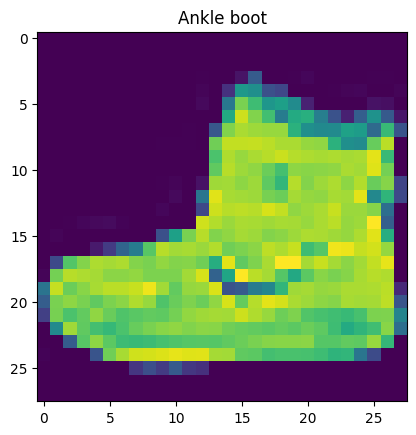

In [24]:
# Visualizing first training sample 
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.show()

In [25]:
# view more sampels
def view_more_samples(data, class_names ,rows , cols ,seed=42):
    """
     function displays a grid of (rows*cols) randomly selected images from the passed dataset,
     with their corresponding labels in class_names.
    :param data: Target dataset which wanted to be showen.
    :param rows: number of images in rows.
    :param columns:  number of images in columns .
    :param seed: random seed value.Defaults to 42.
    """
    torch.manual_seed(seed)
    fig = plt.figure(figsize=(10, 10)) 
    for i in range(1, rows * cols + 1):
        random_idx = torch.randint(0, len(train_data), size=[1]).item()
        img, label = train_data[random_idx]
        plt.subplot(rows, cols, i)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(class_names[label])
        plt.axis(False)

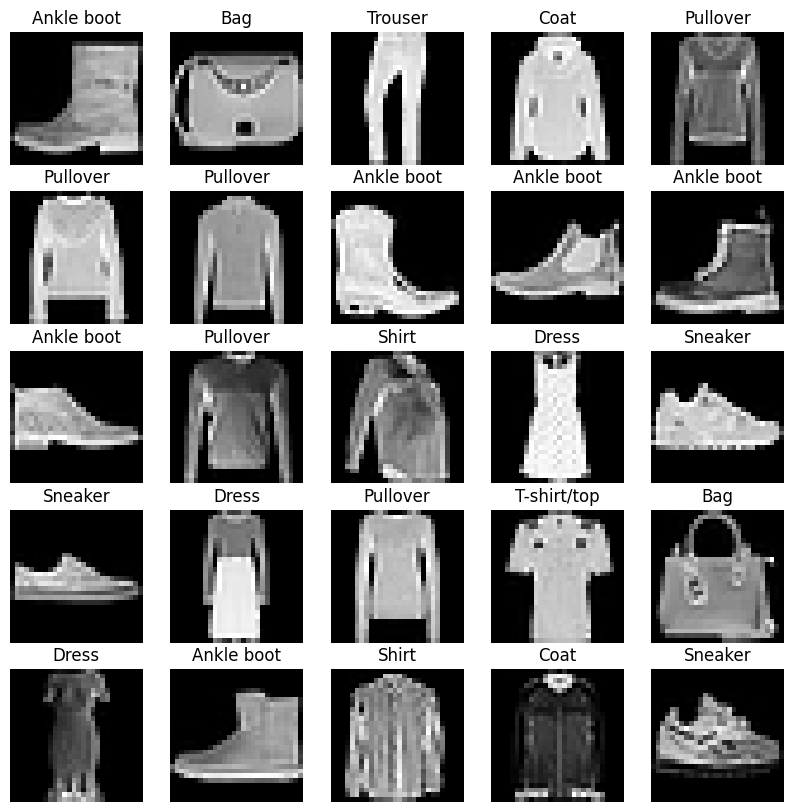

In [26]:
view_more_samples(train_data, class_names,5,5)

# 3. Prepare DataLoader

In [27]:
import  os
from  torch .utils.data import  DataLoader

NUM_WORKERS =os.cpu_count()
def create_dataloaders(train_data,test_data,
                       batch_size:int,num_workers:int=NUM_WORKERS):
    """
    Creates training and testing DataLoaders.
    Takes in a training directory and testing directory path and turns them into PyTorch Datasets and then into PyTorch DataLoaders.

    :param train_dir: Path to training directory.
    :param test_dir: Path to testing directory.
    :param batch_size: Number of samples per batch in each of the DataLoaders.
    :param num_workers: An integer for number of workers per DataLoader.
    :return:
           A tuple of (train_dataloader, test_dataloader, class_names).
           Where class_names is a list of the target classes.
    """
  
    # Get class names
    class_names=train_data.classes

    # Turn Images into data loaders
    train_dataloader=DataLoader(train_data,batch_size=batch_size,shuffle=True,
                                num_workers=num_workers,pin_memory=True)
    test_dataloader=DataLoader(test_data,batch_size=batch_size,shuffle=True,
                               num_workers=num_workers,pin_memory=True)
    return train_dataloader,test_dataloader,class_names

In [28]:
train_dataloader,test_dataloader,class_names=create_dataloaders(train_data=train_data,test_data=test_data,batch_size=32)


In [29]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# 4. Building Model

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Define the dropout layers
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 12 * 12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Pass input through convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # Apply max pooling and dropout
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        
        # Flatten the output from convolutional layers and pass through fully connected layers
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

# Set the seed for reproducibility
torch.manual_seed(42)

# Create an instance of the model and move it to the device (e.g. GPU)
model = FashionMNISTModel().to(device)


# 5. Training Model

In [31]:
from typing import Dict,List,Tuple
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data .DataLoader,
               loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,
               device:torch.device)->Tuple[float,float]:
    """
    Trains a PyTorch model for a single epoch.
    Turns a target PyTorch model to training mode and then runs through all of the required training steps
    (forward pass, loss calculation, optimizer step).
    :param model: A PyTorch model to be trained.
    :param dataloader: A DataLoader instance for the model to be trained on.
    :param loss_fn: A PyTorch loss function to minimize.
    :param optimizer: A PyTorch optimizer to help minimize the loss function.
    :param device: A target device to compute on (e.g. "cuda" or "cpu").
    :return:
     A tuple of training loss and training accuracy metrics.
     In the form (train_loss, train_accuracy).
     For example: (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc =0, 0

    # Loop through data loader , data batches
    for batch ,(X,y) in enumerate(dataloader):
        # send data to target device
        X, y=X.to(device) , y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate and accumulate loss
        loss=loss_fn(y_pred,y)
        train_loss += loss.item()
        # 3. Optimizer zero grade
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += ((y_pred_class == y).sum().item())/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss/ len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss ,train_acc

def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device) -> Tuple[float, float]:
     """
     Tests a PyTorch model for a single epoch.
     Turns a target PyTorch model to "eval" mode and then performs
     a forward pass on a testing dataset.
     :param model: A PyTorch model to be tested.
     :param dataloader: A DataLoader instance for the model to be tested on.
     :param loss_fn: A PyTorch loss function to calculate loss on the test data.
     :param device: A target device to compute on (e.g. "cuda" or "cpu").
     :return:
     A tuple of testing loss and testing accuracy metrics.
     In the form (test_loss, test_accuracy).
     For example: (0.0223, 0.8985)
     """
     # Put model in eval mode
     model.eval()

     #  Setup test loss and test accuracy values
     test_loss ,test_acc= 0,0

     # Turn on inference context manager
     with torch.inference_mode():
         for batch , (X,y) in enumerate(dataloader):
             #  Send data to target device
             X, y= X.to(device) , y.to(device)

             # 1. Forward pass
             test_pred_logits= model(X)

             # 2. Calculate and accumulate loss
             loss =loss_fn(test_pred_logits,y)
             test_loss += loss.item()

             # Calculate and accumulate accuracy
             test_pred_labels = test_pred_logits.argmax(dim=1)
             test_acc += ((test_pred_labels == y).sum().item())/len(test_pred_labels)
     # Adjust metrics to get average loss and accuracy per batch
     test_loss =test_loss/ len(dataloader)
     test_acc = test_acc / len(dataloader)
     return  test_loss , test_acc

def train (model: torch.nn.Module,
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader,
           optimizer: torch.optim.Optimizer,
           loss_fn: torch.nn.Module,
           epochs: int,
           device: torch.device) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.
    Passes a target PyTorch models through train_step() and test_step() functions for a number of epochs, training and testing the model in the same epoch loop.
    Calculates, prints and stores evaluation metrics throughout.

    :param model: A PyTorch model to be trained and tested.
    :param train_dataloader: A DataLoader instance for the model to be trained on.
    :param test_dataloader: A DataLoader instance for the model to be tested on.
    :param optimizer: A PyTorch optimizer to help minimize the loss function.
    :param loss_fn: A PyTorch loss function to calculate loss on both datasets.
    :param epochs: An integer indicating how many epochs to train for.
    :param device: A target device to compute on (e.g. "cuda" or "cpu").
    :return:
    A dictionary of training and testing loss as well as training and testing accuracy metrics.
    Each metric has a value in a list for each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
              t   test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]}

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss , train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


In [32]:
# setup optimizer
optimizer=torch.optim.Adam(params=model.parameters(),lr=1e-3)

# setup loss function
loss_fn=torch.nn.CrossEntropyLoss()


model_results= train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        epochs=15,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device)

Epoch: 1 | train_loss: 0.5074 | train_acc: 0.8192 | test_loss: 0.3200 | test_acc: 0.8811
Epoch: 2 | train_loss: 0.3468 | train_acc: 0.8772 | test_loss: 0.2750 | test_acc: 0.9001
Epoch: 3 | train_loss: 0.2994 | train_acc: 0.8929 | test_loss: 0.2553 | test_acc: 0.9064
Epoch: 4 | train_loss: 0.2737 | train_acc: 0.9021 | test_loss: 0.2412 | test_acc: 0.9130
Epoch: 5 | train_loss: 0.2551 | train_acc: 0.9076 | test_loss: 0.2295 | test_acc: 0.9139
Epoch: 6 | train_loss: 0.2400 | train_acc: 0.9127 | test_loss: 0.2258 | test_acc: 0.9172
Epoch: 7 | train_loss: 0.2245 | train_acc: 0.9191 | test_loss: 0.2216 | test_acc: 0.9199
Epoch: 8 | train_loss: 0.2212 | train_acc: 0.9202 | test_loss: 0.2207 | test_acc: 0.9209
Epoch: 9 | train_loss: 0.2084 | train_acc: 0.9242 | test_loss: 0.2108 | test_acc: 0.9241
Epoch: 10 | train_loss: 0.2014 | train_acc: 0.9268 | test_loss: 0.2252 | test_acc: 0.9240
Epoch: 11 | train_loss: 0.1936 | train_acc: 0.9294 | test_loss: 0.2383 | test_acc: 0.9213
Epoch: 12 | train_l

In [33]:
# # setup optimizer
# optimizer=torch.optim.SGD(params=model.parameters(),lr=1e-3)

# # setup loss function
# loss_fn=torch.nn.CrossEntropyLoss()


# model_results= train(model=model,
#                         train_dataloader=train_dataloader,
#                         test_dataloader=test_dataloader,
#                         epochs=10,
#                         optimizer=optimizer,
#                         loss_fn=loss_fn,
#                         device=device)

In [34]:
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.
    :param results: dictionary containing list of values, e.g.
                    {"train_loss": [...],
                     "train_acc": [...],
                     "test_loss": [...],
                     "test_acc": [...]}
    :return: loss curves
    """

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

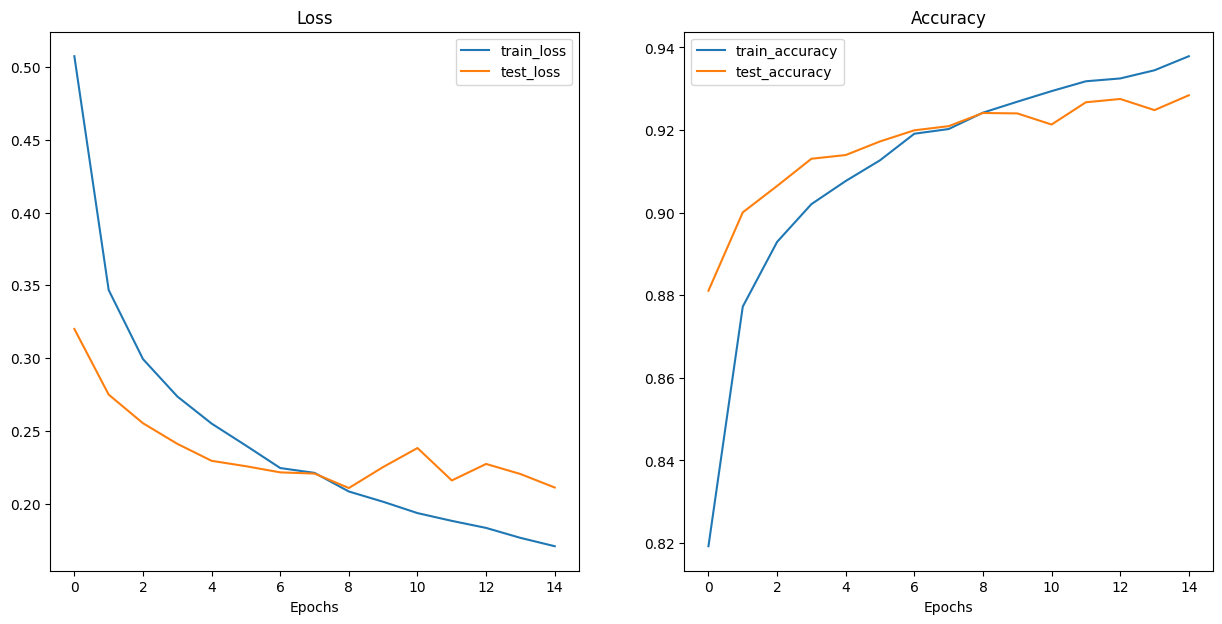

In [35]:
plot_loss_curves(model_results)


# 6. Make and evaluate random predictions

In [36]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [37]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [38]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[8.6444e-12, 1.5906e-20, 8.0891e-15, 1.8592e-21, 6.8200e-21, 1.0000e+00,
         1.6353e-15, 1.5066e-10, 7.8767e-10, 6.4742e-09],
        [1.1881e-06, 1.0000e+00, 1.9111e-08, 2.6977e-08, 1.9826e-09, 6.5642e-12,
         3.3256e-07, 1.7716e-14, 1.9691e-09, 9.3553e-13]])

In [39]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

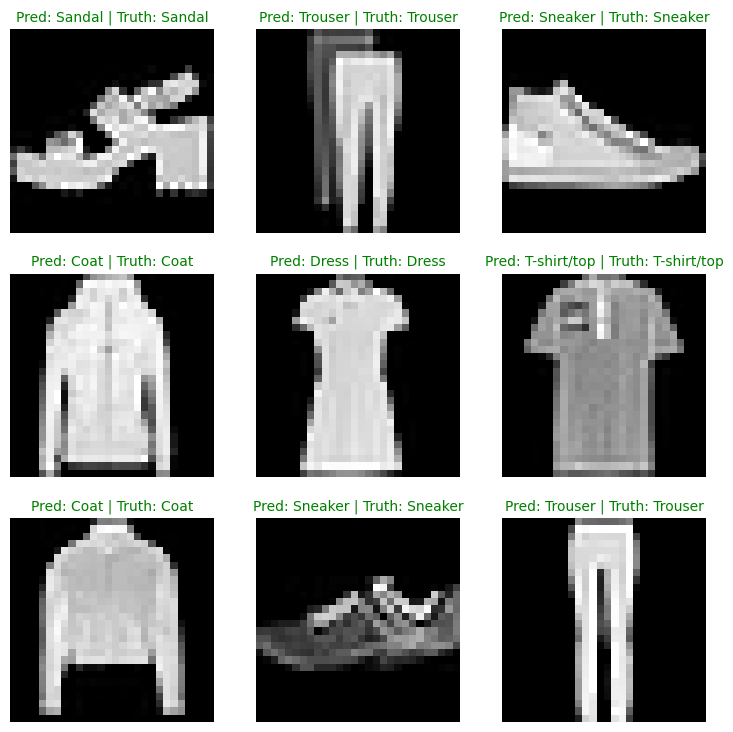

In [40]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# 7. Making a confusion matrix for further prediction evaluation

In [41]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [42]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.21.0


In [43]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.21.0


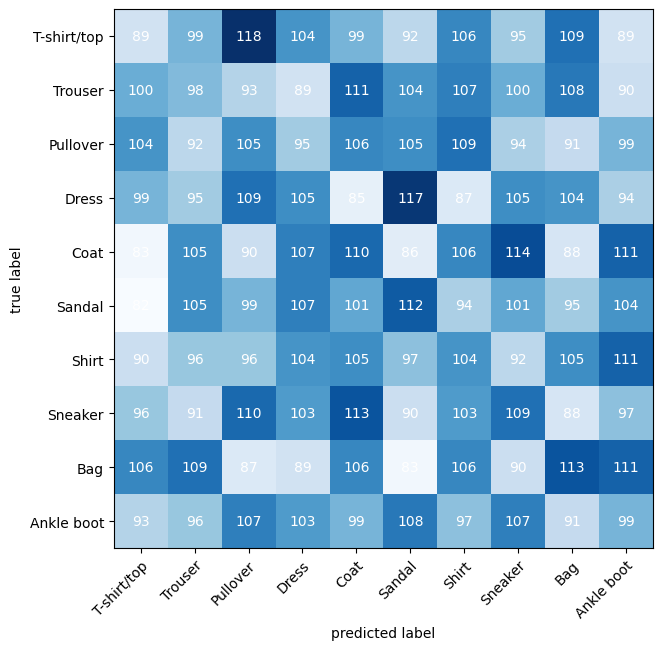

In [44]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)

In [45]:
import sklearn.metrics as metrics

y_preds = []
y_true = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred)
        y_true.append(y)

y_preds = torch.cat(y_preds).flatten().tolist()
y_true = torch.cat(y_true).flatten().tolist()

print("Classification report for CNN :\n%s\n" % (metrics.classification_report(y_true, y_preds)))


Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.90      0.89      1000
           3       0.93      0.93      0.93      1000
           4       0.87      0.90      0.88      1000
           5       0.99      0.98      0.99      1000
           6       0.78      0.79      0.78      1000
           7       0.97      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000




# 8. Save best performing model

In [47]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "fasion_eminst_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/fasion_eminst_model.pth
